In [1]:
pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:00


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Montage de Google Drive pour accéder aux fichiers
drive.mount('/content/drive')

# Chargement des données à partir de Google Drive
bdd = pd.read_csv('/content/drive/My Drive/bdd.csv', index_col=0, parse_dates=True)
taux_change = pd.read_csv('/content/drive/My Drive/taux_change.csv', index_col=0, parse_dates=True)

# Préparation des données de taux de change
taux_change.drop(columns=['EUR/CHF'], inplace=True)

# Affichage des premières lignes des DataFrames
display(bdd)
display(var_taux_change)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,SR_1Y,SR_3Y,SR_5Y,SR_10Y,SR_20Y,SR_30Y,STOX50,S&P500
Date,,,,,,,,
2007-03-30,3.921181,3.932365,3.927126,4.024396,4.193160,4.268851,4181.029785,1420.859985
2007-04-02,3.934280,3.956157,3.945002,4.030000,4.204120,4.287639,4189.549805,1424.550049
2007-04-03,3.941438,3.968073,3.966270,4.064232,4.234304,4.311176,4246.299805,1437.770020
2007-04-04,3.936594,3.947791,3.944578,4.052252,4.234595,4.315807,4261.830078,1439.369995
2007-04-05,3.938785,3.954474,3.953399,4.060667,4.239597,4.319013,4271.540039,1443.760010
...,...,...,...,...,...,...,...,...
2024-06-14,3.107870,2.541109,2.338506,2.408687,2.653216,2.531207,4839.140137,5431.600098
2024-06-17,3.115303,2.586249,2.404907,2.487404,2.706389,2.561350,4880.419922,5473.229980
2024-06-18,3.121078,2.586010,2.400618,2.476221,2.689464,2.546050,4915.470215,5487.029785


,EUR/USD,EUR/GBP,EUR/JPY,EUR/AUD
Date,,,,
2004-12-02,-0.006365,-0.001738,-0.000950,-0.002041
2004-12-03,0.015459,0.005079,0.005487,0.005492
2004-12-06,-0.005198,-0.002166,0.005239,0.006333
2004-12-07,0.002606,-0.001013,0.000072,-0.000346
2004-12-08,-0.006392,-0.002462,0.004343,0.018482
...,...,...,...,...
2023-04-25,0.006116,0.001846,0.006778,0.004348
2023-04-26,-0.007334,-0.000509,-0.009815,0.002928
2023-04-27,0.006275,0.001674,0.004047,0.010296


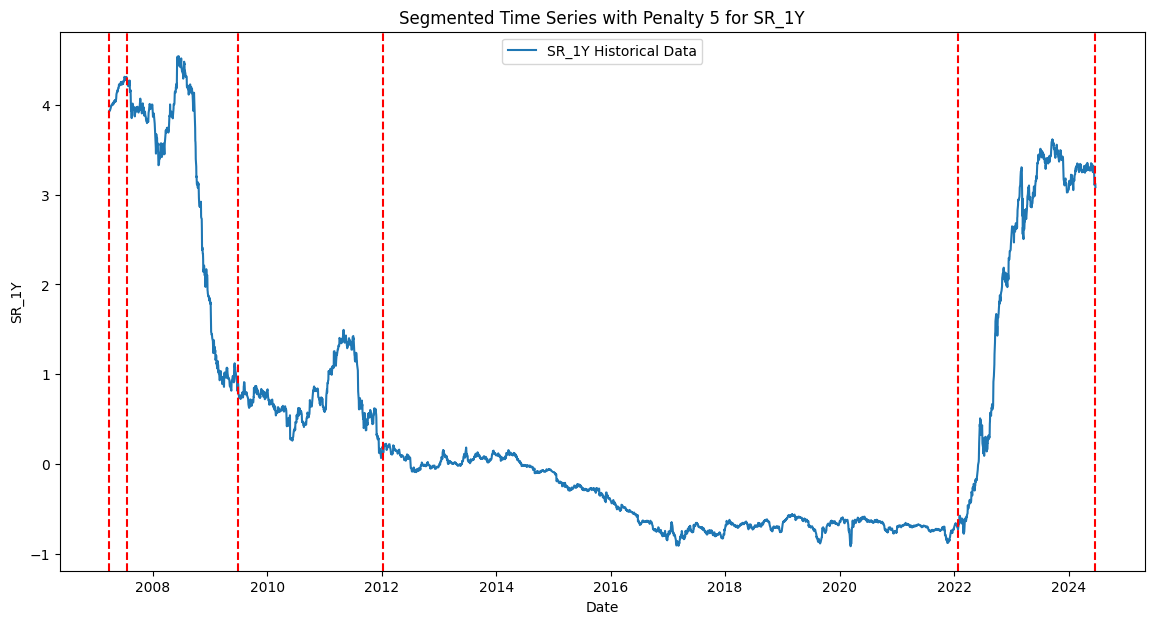

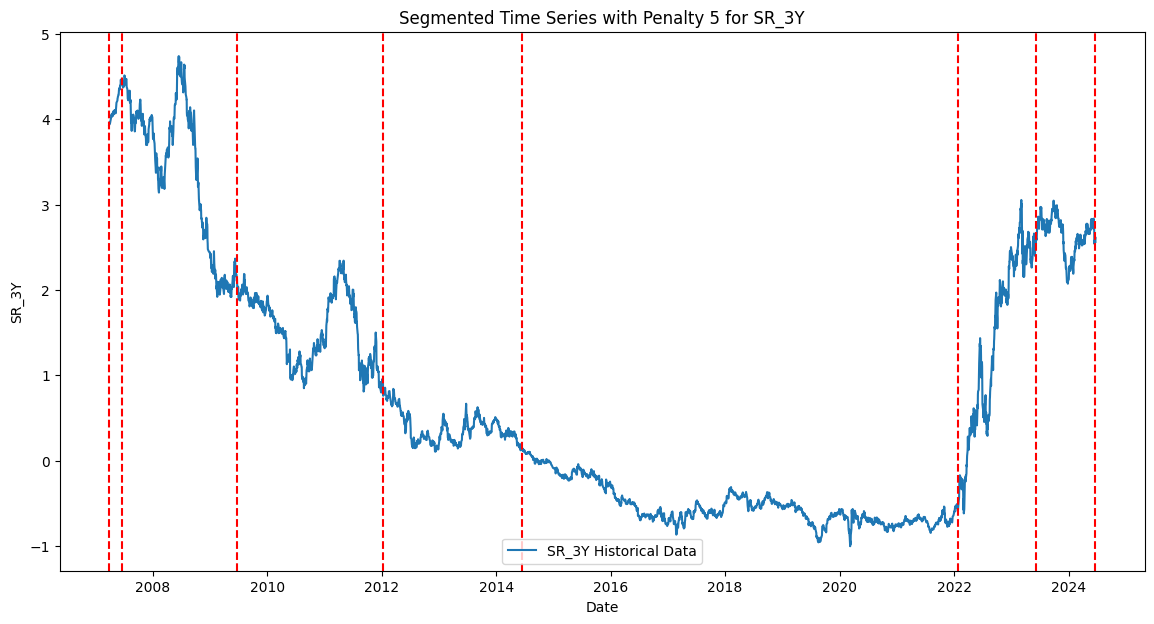

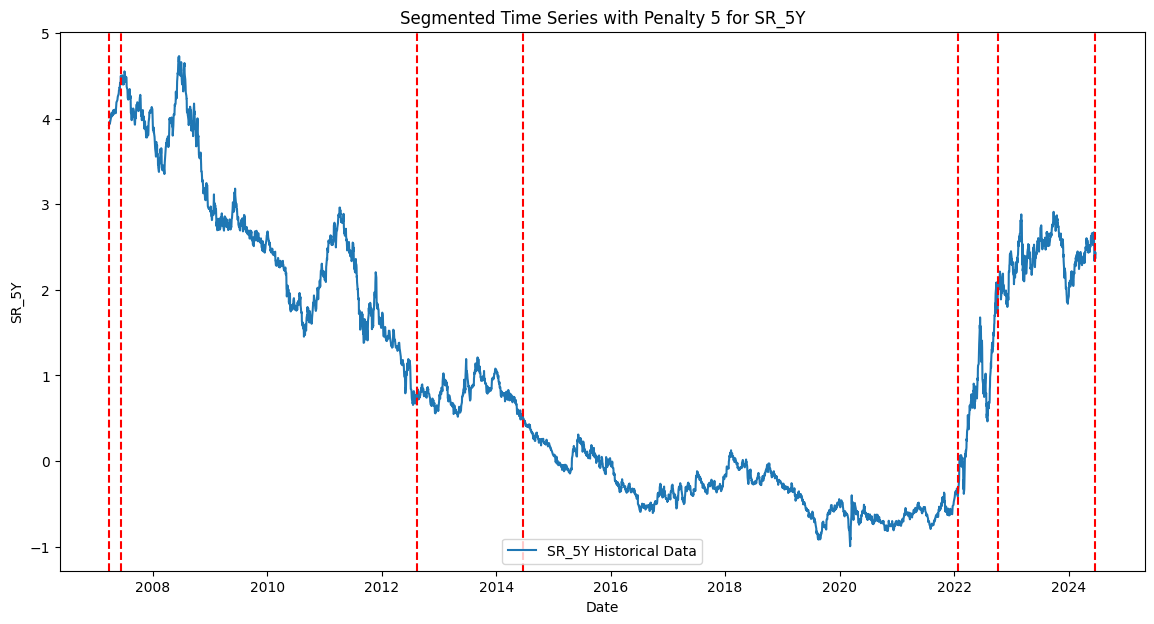

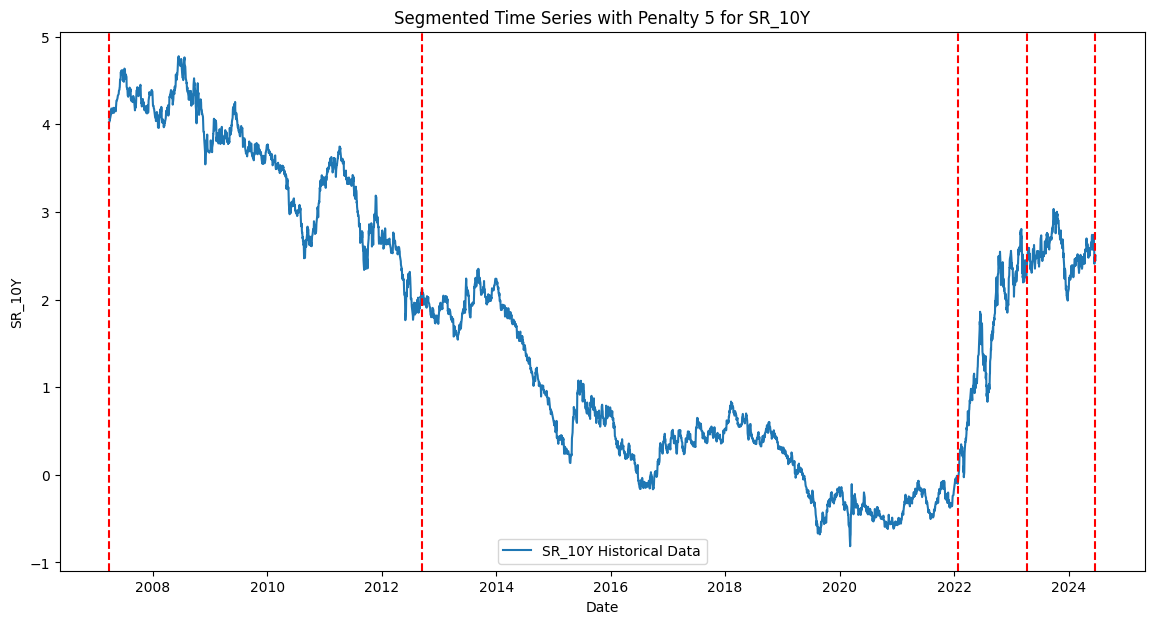

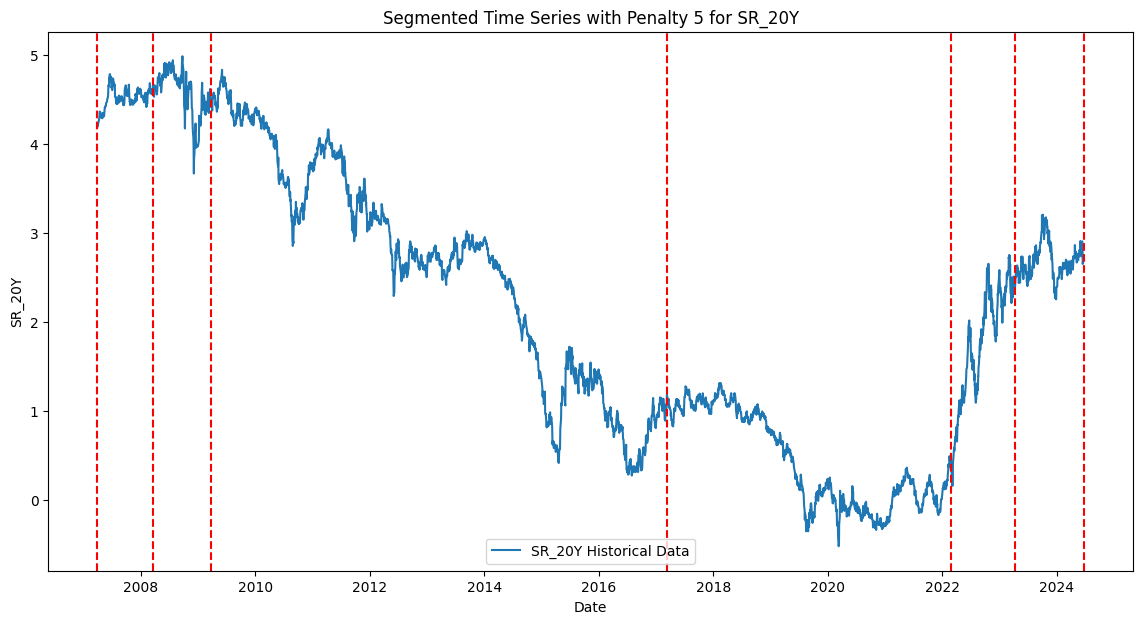

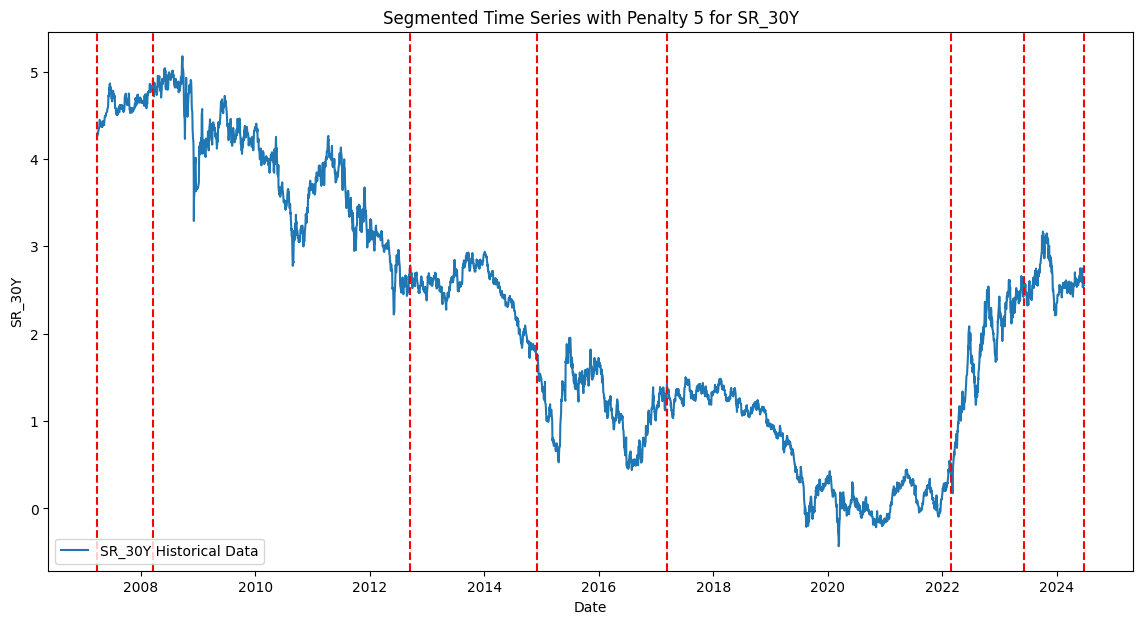

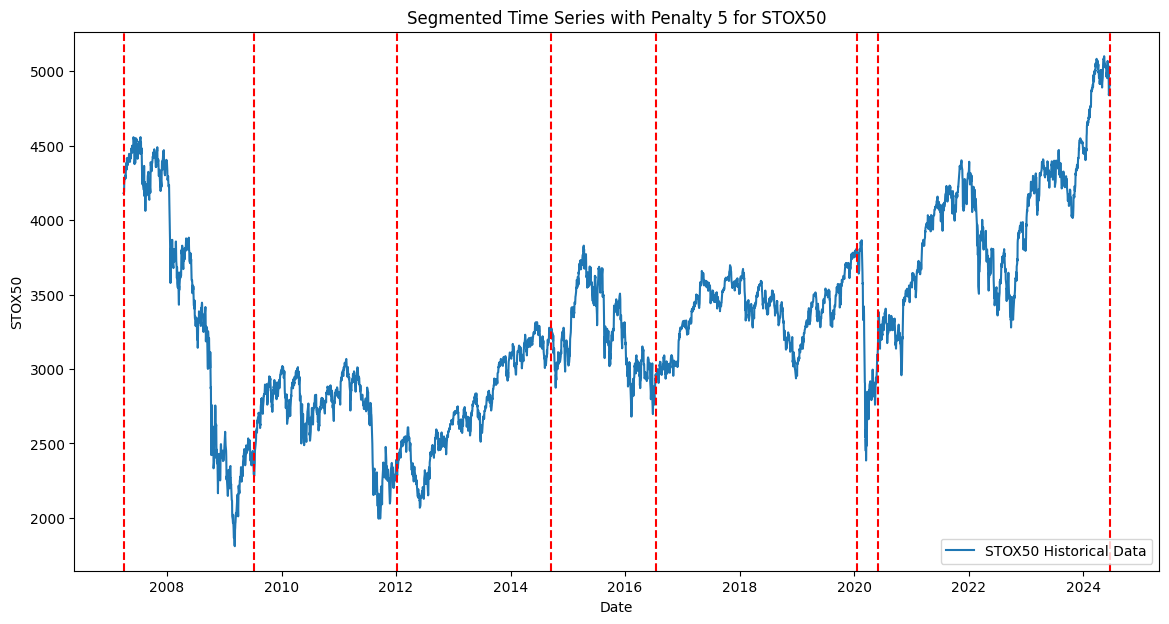

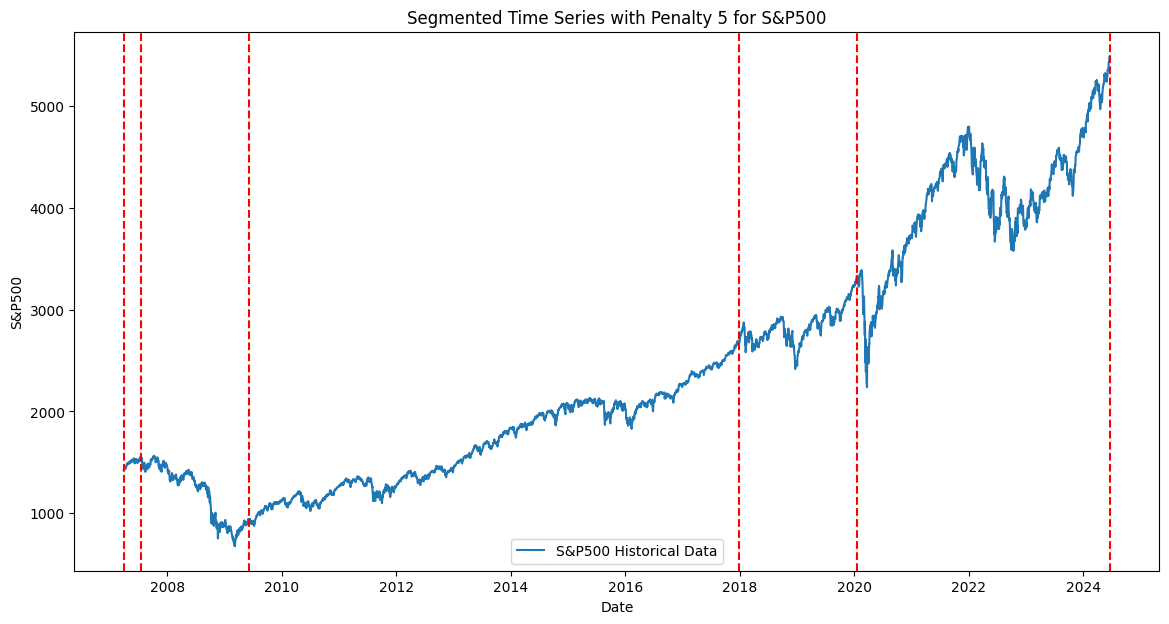

213.5784432888031


In [52]:
# Fonction pour segmenter et afficher les séries temporelles
def segment_and_plot(df, penalty=5):
    all_break = {}
    for column_name in df.columns:
        data = np.diff(df[column_name].dropna().values)
        algo = rpt.Binseg(model="rbf").fit(data)
        result = algo.predict(pen=penalty)
        result = [bkpt for bkpt in result if bkpt < len(df)]
        result.insert(0, 0)
        all_break[column_name] = result

        # Visualisation des segments
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df[column_name], label=f'{column_name} Historical Data')
        for bkpt in result:
            plt.axvline(x=df.index[bkpt], color='r', linestyle='--')
        plt.title(f'Segmented Time Series with Penalty {penalty} for {column_name}')
        plt.xlabel('Date')
        plt.ylabel(column_name)
        plt.legend()
        plt.show()
    return all_break

# Exemple d'utilisation de la fonction de segmentation
start_time = time.time()
bkpt = segment_and_plot(bdd)
end_time = time.time()
print(end_time - start_time)

1.0


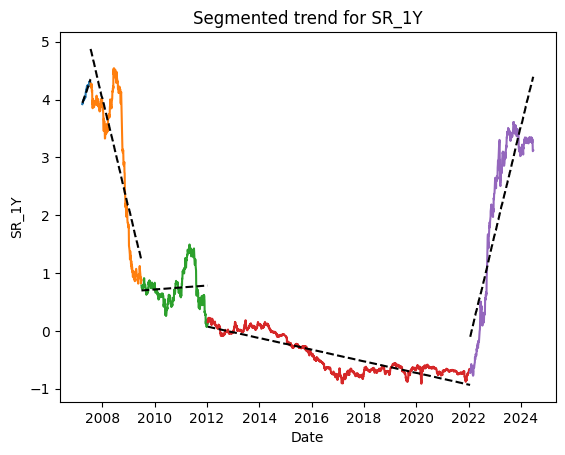

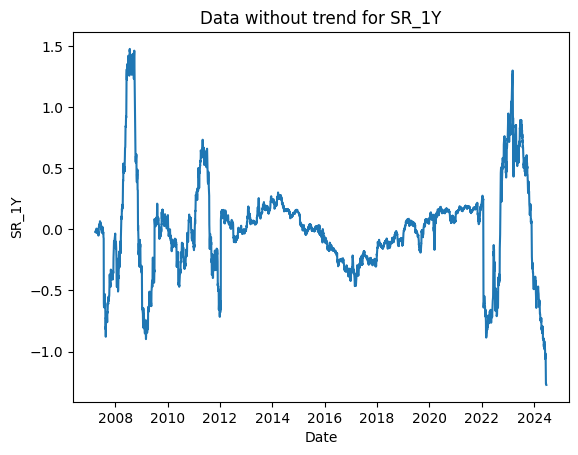

1.0


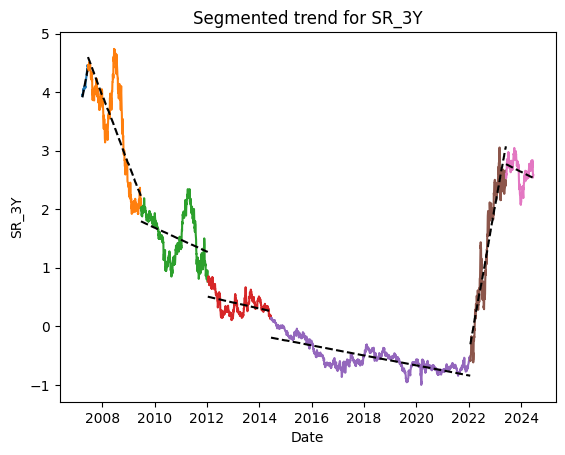

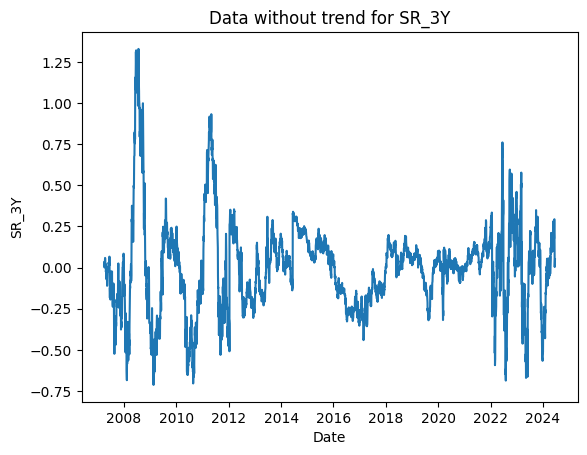

1.0


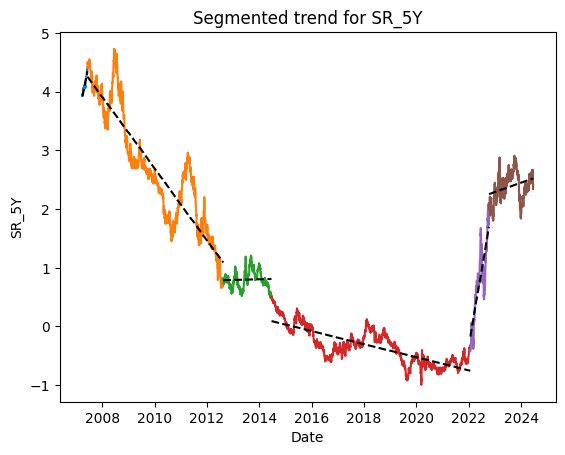

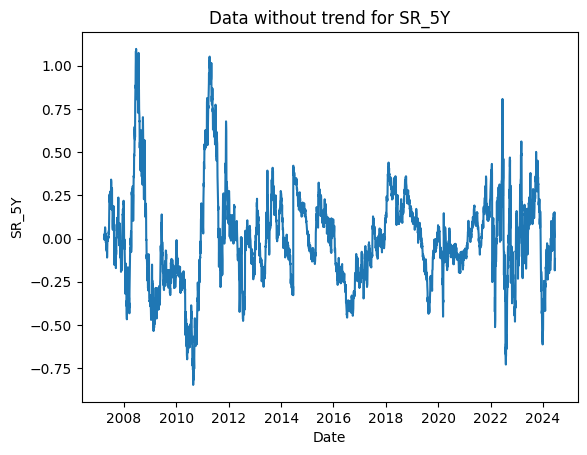

1.0


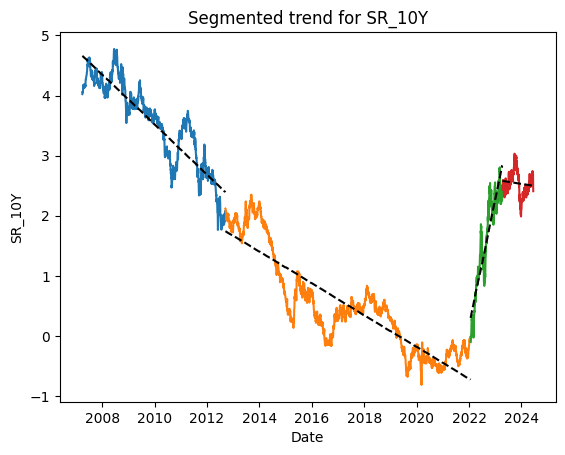

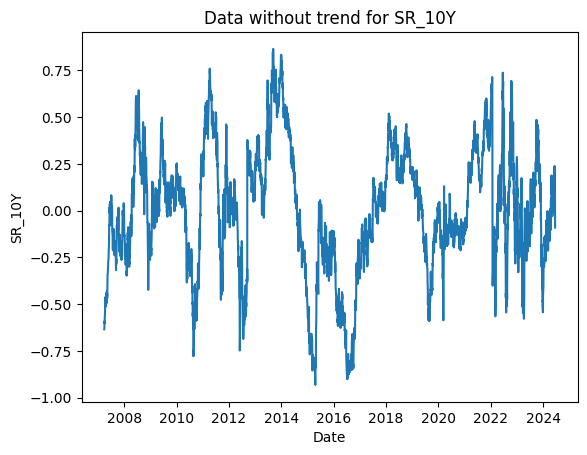

1.0


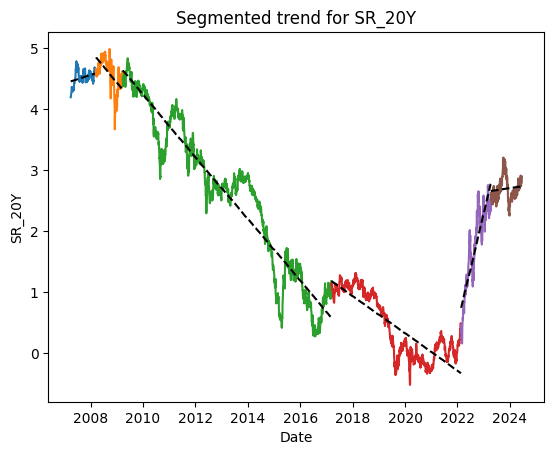

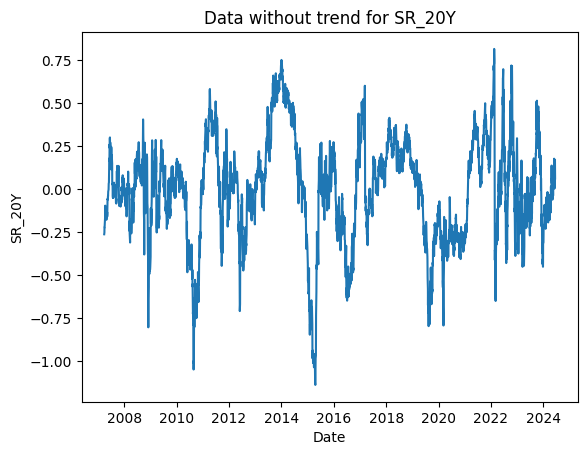

1.0


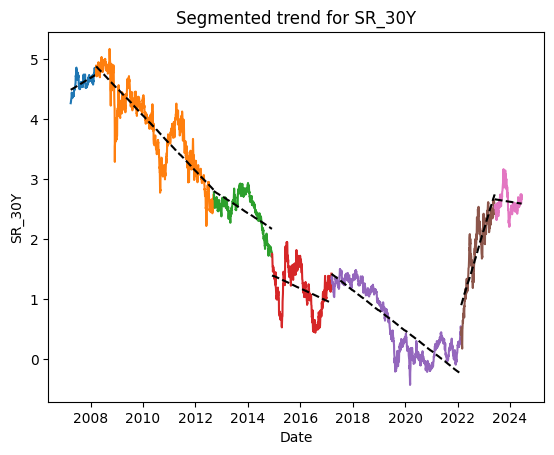

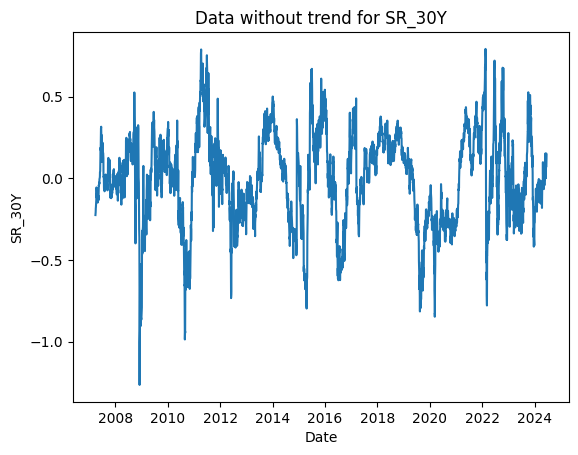

1.0


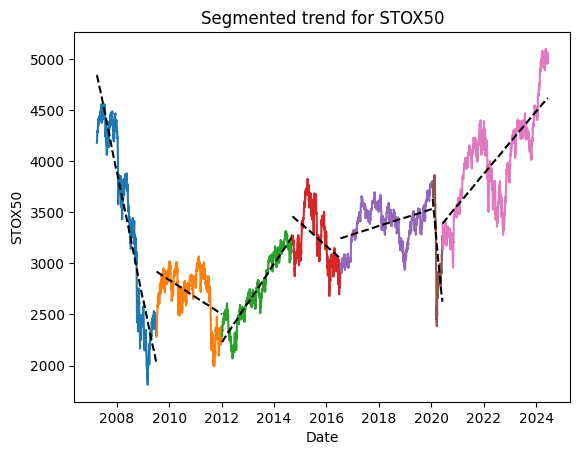

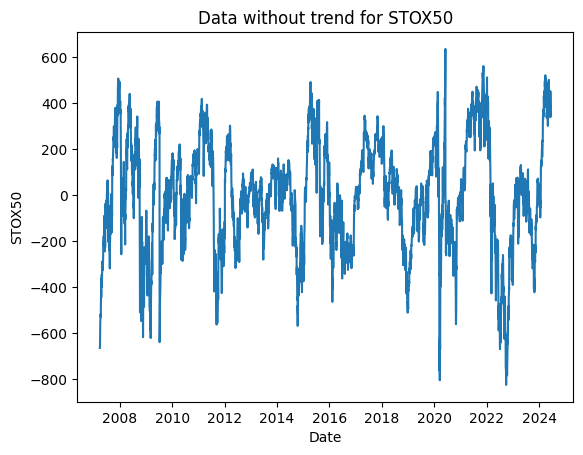

1.0


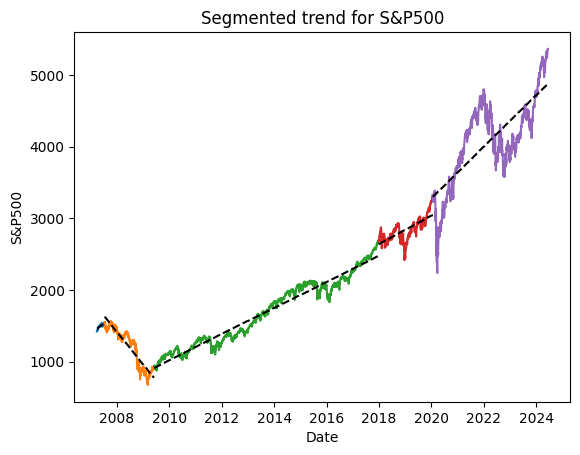

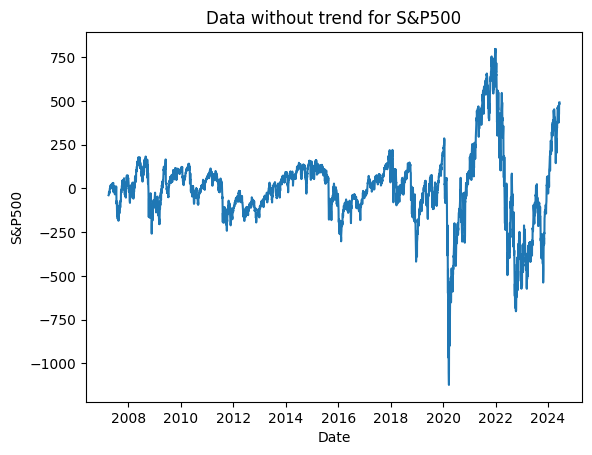

In [53]:
# Fonction pour calculer et afficher les tendances des segments
def trend(df, dico):
    dico_slope = {}
    dico_proba = {}
    length_tot = df.shape[0]
    for column_name in df.columns:
        proba = []
        slope = []
        data = []
        bkpt = dico[column_name]
        df = df.iloc[:-1]
        for i in range(len(bkpt) - 1):
            y = df[column_name].iloc[bkpt[i]:bkpt[i+1]]
            x = range(len(y))
            res = linregress(x, y)
            plt.plot(df[column_name].index[bkpt[i]:bkpt[i+1]], y)
            plt.plot(df[column_name].index[bkpt[i]:bkpt[i+1]], res.slope * x + res.intercept, color='black', linestyle='--')
            data.extend(y - res.slope * x - res.intercept)
            slope.append(res.slope)
            proba.append(len(x) / length_tot)
        print(round(sum(proba), 2))
        dico_proba[column_name] = proba
        dico_slope[column_name] = slope
        df[column_name] = data

        # Affichage des tendances et des données sans tendance
        plt.title(f'Segmented trend for {column_name}')
        plt.xlabel('Date')
        plt.ylabel(column_name)
        plt.show()
        plt.plot(df[column_name].index, data)
        plt.title(f'Data without trend for {column_name}')
        plt.xlabel('Date')
        plt.ylabel(column_name)
        plt.show()
    return df, dico_slope, dico_proba

# Calcul des tendances et nettoyage des données
bdd_clean, dico_slope, dico_proba = trend(bdd, bkpt)

In [54]:
bdd_clean=bdd_clean.diff().dropna()

# Fonction pour supprimer les outliers
def remove_outliers(df, threshold):
  for column_name in df.columns:
    mean = df[column_name].mean()
    std = df[column_name].std()
    df['Z_score'] = (df[column_name] - mean) / std
    if df['Z_score'].abs().max() > threshold:
      print(column_name)
    df_clean = df[np.abs(df['Z_score']) <= threshold].copy()
    df_clean.drop(columns=['Z_score'], inplace=True)
  return df_clean
print(bdd.shape)
# Supprimer les outliers
diff_bdd = remove_outliers(bdd_clean, threshold=5)
print(diff_bdd)
scaler = MinMaxScaler()

# Normalisez vos données en ajustant et en transformant votre DataFrame
normalized_data = scaler.fit_transform(diff_bdd)

# Le résultat de la normalisation sera un tableau NumPy
diff_bdd_norm = pd.DataFrame(normalized_data, columns=diff_bdd.columns)
diff_bdd_norm=diff_bdd_norm.iloc[1:]
display(diff_bdd_norm)


(4221, 8)
SR_1Y
SR_3Y
SR_5Y
SR_10Y
SR_20Y
SR_30Y
STOX50
S&P500
               SR_1Y     SR_3Y     SR_5Y    SR_10Y    SR_20Y    SR_30Y  \
Date                                                                     
2007-04-02  0.007565  0.013462  0.008156  0.007290  0.010394  0.017711   
2007-04-03  0.001623  0.001587  0.011548  0.035919  0.029618  0.022460   
2007-04-04 -0.010379 -0.030610 -0.031411 -0.010294 -0.000274  0.003553   
2007-04-05 -0.003343 -0.003646 -0.000899  0.010102  0.004436  0.002128   
2007-04-10  0.023056  0.034631  0.037684  0.046875  0.041391  0.039920   
...              ...       ...       ...       ...       ...       ...   
2024-06-04 -0.053322 -0.052407 -0.058102 -0.063767 -0.069371 -0.064887   
2024-06-05  0.015814 -0.002923 -0.019256 -0.029547 -0.025286 -0.018196   
2024-06-06 -0.006172  0.048102  0.058064  0.054488  0.047831  0.041504   
2024-06-07  0.035410  0.065414  0.069437  0.065239  0.050107  0.039046   
2024-06-10 -0.015530  0.004034  0.019394  0.05202

,SR_1Y,SR_3Y,SR_5Y,SR_10Y,SR_20Y,SR_30Y,STOX50,S&P500
1,0.539847,0.425305,0.460125,0.599912,0.832664,0.607114,0.826204,0.544584
2,0.532301,0.401230,0.428692,0.574393,0.809149,0.597027,0.792042,0.503743
3,0.536724,0.421392,0.451018,0.585656,0.812854,0.596266,0.787218,0.513549
4,0.553320,0.450014,0.479248,0.605962,0.841925,0.616430,0.803976,0.514393
5,0.542303,0.425184,0.452420,0.586196,0.817029,0.600573,0.772316,0.464660
...,...,...,...,...,...,...,...,...
4190,0.505305,0.384931,0.409163,0.544866,0.754795,0.560510,0.732329,0.525095
4191,0.548768,0.421933,0.437586,0.563762,0.789473,0.585422,0.842110,0.717524
4192,0.534946,0.460087,0.494160,0.610166,0.846991,0.617275,0.801615,0.493428
4193,0.561086,0.473032,0.502482,0.616103,0.848781,0.615964,0.759173,0.476207


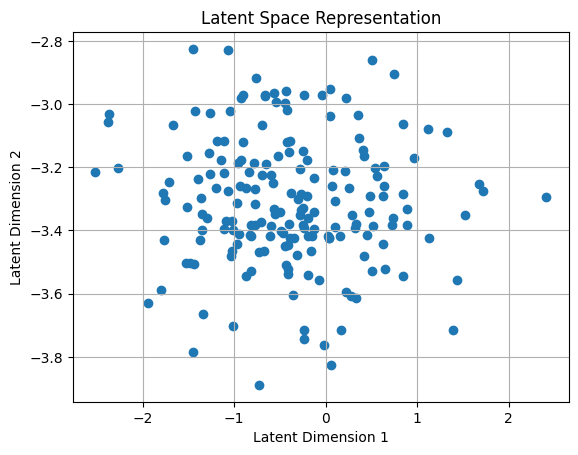

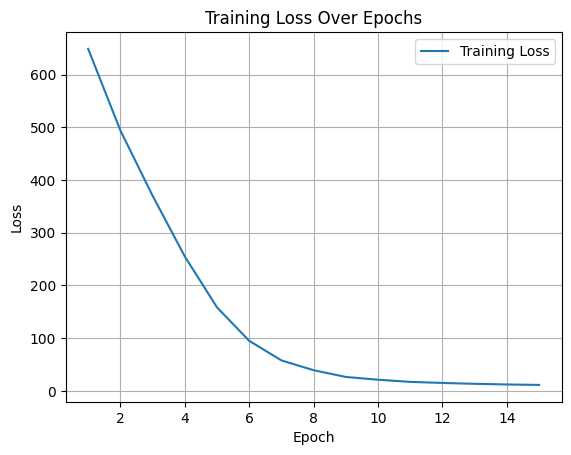

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot  as plt
# Fixer la graine pour garantir des résultats reproductibles
seed_value = 42
np.random.seed(seed_value)

#Definission des dimension des couches intermediares
dim_i=7
dim7=6
# Définir le modèle VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, dim_i)
        self.fc7=nn.Linear(dim_i,dim7)
        self.fcf=nn.Linear(dim7,latent_dim)
        self.fc2_mu = nn.Linear(dim_i, latent_dim)
        self.fc2_logvar = nn.Linear(dim_i, latent_dim)
        self.fc3 = nn.Linear(latent_dim, dim_i)
        self.fc4 = nn.Linear(dim_i, input_dim)
        self.relu = nn.ReLU()
        self.selu=nn.SELU()

    def encode(self, x):
        h1 = self.selu(self.fc7(self.fc1(x)))
        return self.fcf(h1), self.fcf(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * std

    def decode(self, z):
        h3 = self.selu(self.fc3(z))
        return self.fc4(h3)  # Supprimer torch.sigmoid pour les valeurs continues

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -1 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0.99*MSE + 0.001*KLD

# Convertir le DataFrame consolidé en tableau NumPy et en tenseur PyTorch
consolidated_array = diff_bdd_norm.to_numpy()
consolidated_tensor = torch.Tensor(consolidated_array)

# Créer un TensorDataset avec le tenseur PyTorch
train_data = TensorDataset(consolidated_tensor)

# Spécifier la taille du batch
batch_size = 211
# Créer un DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Définir les dimensions du modèle
input_dim = consolidated_tensor.shape[1]
latent_dim = 3

# Créer une instance du modèle et définir l'optimiseur
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entraîner le modèle
losses = []
num_epochs = 15
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        # batch est un tuple contenant un seul élément (les données)
        data_batch = batch[0]
        #print(data_batch.shape)
        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Propagation avant
        reconstructed, mu, logvar = model(data_batch)

        # Calcul de la perte
        loss = loss_function(reconstructed, data_batch, mu, logvar)
        loss.backward()

        # Mise à jour des poids
        optimizer.step()
        epoch_loss += loss.item()  # Ajouter la perte de ce batch à la perte totale de l'époque
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    epoch_loss /= len(train_loader)  # Calculer la perte moyenne pour cette époque
    losses.append(epoch_loss)  # Ajouter la perte moyenne à la liste des pertes

with torch.no_grad():
        encoded_data = model.reparameterize(mu,logvar)
        latent_means = encoded_data.numpy()
        plt.scatter(latent_means[:, 0], latent_means[:, 1])
        plt.title('Latent Space Representation')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid(True)
        plt.show()

"""with torch.no_grad():
    encoded_data = model.encode(data_batch)
    latent_means = encoded_data[0].numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(latent_means[:, 0], latent_means[:, 1], latent_means[:, 2])
    ax.set_title('Latent Space Representation')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')
    plt.grid(True)
    plt.show()
"""
# Tracer la courbe de la fonction de perte
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [120]:
import numpy as np
# Nombre de scénarios et points par scénario
num_scenarios = 500

nb_point=2000#ENGROS



mu_mean = mu.mean(dim=0, keepdim=True)
logvar_mean = logvar.mean(dim=0, keepdim=True)

# Répéter les valeurs moyennes pour obtenir les dimensions nécessaires
mu = mu_mean.repeat(nb_point, 1)
logvar = logvar_mean.repeat(nb_point, 1)

# Initialiser une liste pour stocker tous les scénarios générés
all_generated_scenarios = []

for _ in range(num_scenarios):
    with torch.no_grad():

        # Échantillonner les vecteurs latents mu et logvar
      #mu = torch.zeros(nb_point, latent_dim)
      #logvar = torch.zeros(nb_point, latent_dim)
      z= model.reparameterize(mu, logvar)

      generated_scenarios = model.decode(z).detach().numpy() # Décoder les vecteurs latents

      all_generated_scenarios.append(generated_scenarios)

print(generated_scenarios.shape)
# Convertir la liste de scénarios en un seul DataFrame
all_generated_scenarios = np.concatenate(all_generated_scenarios, axis=0)
generated_df = pd.DataFrame(all_generated_scenarios, columns=diff_bdd.columns)

# Inverser la transformation des données si nécessaire
generated_df = pd.DataFrame(scaler.inverse_transform(generated_df), columns=diff_bdd.columns)
print(generated_df.shape)


(2000, 8)
(1000000, 8)


In [104]:
def normalize_variance(generated_data, historical_data, window_size,facteur_visuelle):
    # Calculate the rolling standard deviation of the historical data
    historical_std = historical_data.rolling(window=window_size).std().dropna().values[-1]

    # Calculate the standard deviation of the generated data
    generated_std = np.std(generated_data)

    # Scale the generated data to match the historical standard deviation
    # Check if the generated data's variance is significantly different from the historical data's variance
    if generated_std > historical_std :
        # Scale the generated data to match the historical standard deviation
        scaled_data = generated_data * facteur_visuelle*(historical_std / generated_std)
        return scaled_data
    else:
        return generated_data

In [115]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def calculer_matrice_transition(dico_proba):
    # Initialisation du dictionnaire pour stocker les matrices de transition
    matrices_transition = {}

    for key, proba in dico_proba.items():
        # Conversion de la liste de probabilités en tableau numpy et normalisation
        p = np.array(proba).reshape(-1, 1)
        scalerp = MinMaxScaler()
        proba_norm = scalerp.fit_transform(p)

        # Calcul de la diagonale de la matrice de transition
        diag_elements = proba_norm * 0.4 + 0.5
        diag_elements = diag_elements.flatten()

        # Initialisation de la matrice de transition avec des zéros
        n = len(proba)
        matrice_transition = np.zeros((n, n))

        # Remplir la diagonale de la matrice de transition
        np.fill_diagonal(matrice_transition, diag_elements)

        # Remplir les autres éléments de la matrice de transition en utilisant les probabilités normalisées
        for i in range(n):
            somme_proba = sum(proba[j] for j in range(n) if j != i)
            for j in range(n):
                if i != j:
                    matrice_transition[i, j] = proba[j] / somme_proba * (1 - diag_elements[i])

        # Stocker la matrice de transition dans le dictionnaire
        matrices_transition[key] = matrice_transition

    return matrices_transition



matrices_transition = calculer_matrice_transition(dico_proba)

for key, matrix in matrices_transition.items():
    print(f"{key}:\n{matrix}\n")


# Fonction pour normaliser les probabilités
def normaliser_probabilites(probabilities):
    total = sum(probabilities)
    return [p / total for p in probabilities]

SR_1Y:
[[0.5        0.05729795 0.07599517 0.29553679 0.07117008]
 [0.00866418 0.56736842 0.07277914 0.28303    0.06815825]
 [0.00849289 0.0537883  0.59347368 0.27743439 0.06681073]
 [0.00423729 0.02683616 0.03559322 0.9        0.03333333]
 [0.00853849 0.05407713 0.07172336 0.27892417 0.58673684]]

SR_3Y:
[[0.5        0.05936675 0.07615735 0.07016071 0.22367474 0.0401775
  0.03046294]
 [0.00539646 0.59807163 0.06853505 0.06313859 0.20128797 0.03615629
  0.02741402]
 [0.00517682 0.05125051 0.62892562 0.06056878 0.19309535 0.03468469
  0.02629824]
 [0.00525721 0.05204633 0.0667665  0.61790634 0.19609375 0.03522327
  0.0267066 ]
 [0.00212404 0.02102804 0.02697536 0.02485132 0.9        0.0142311
  0.01079014]
 [0.00562809 0.0557181  0.07147675 0.06584866 0.20992778 0.56280992
  0.0285907 ]
 [0.00573823 0.05680844 0.07287547 0.06713724 0.21403583 0.03844611
  0.54495868]]

SR_5Y:
[[0.5        0.15336688 0.05331896 0.22286125 0.02096813 0.04948478]
 [0.00348947 0.77217631 0.03450699 0.1442314

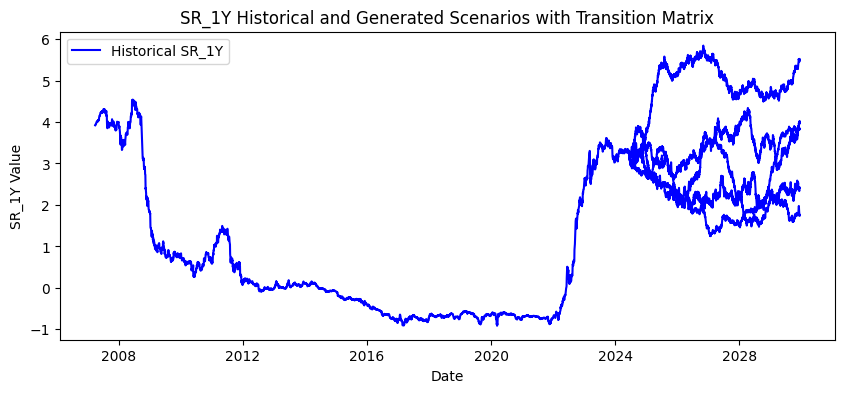

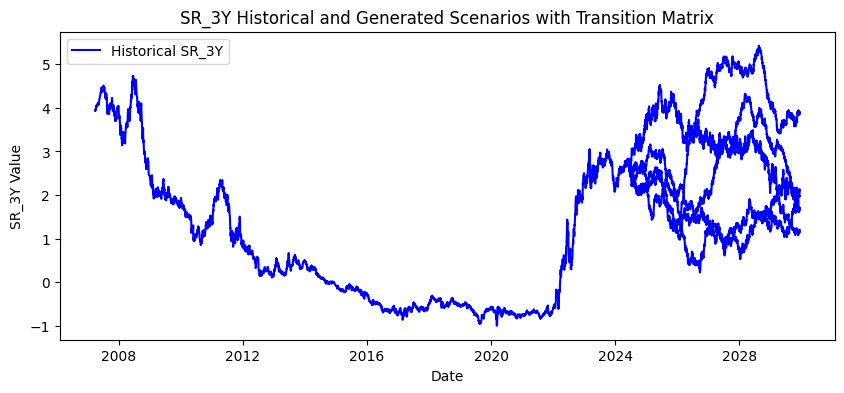

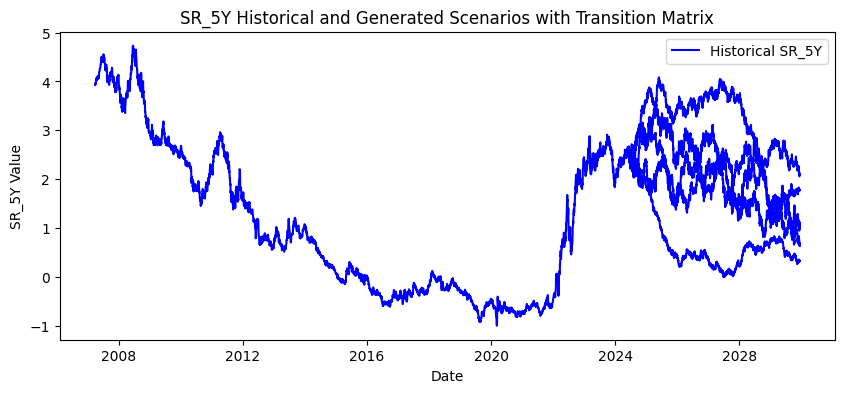

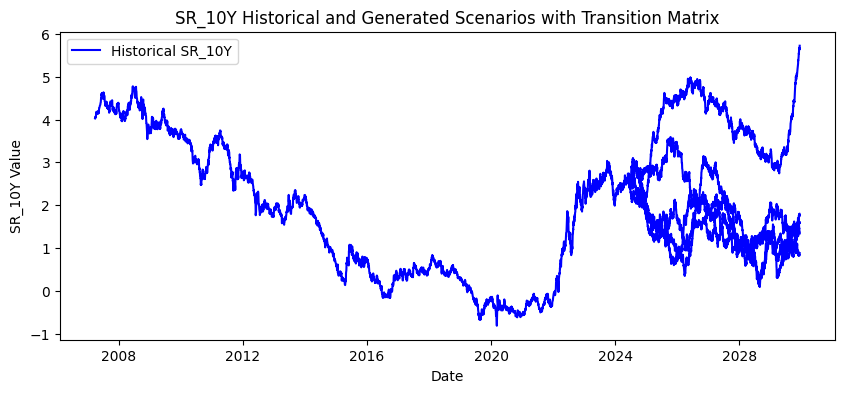

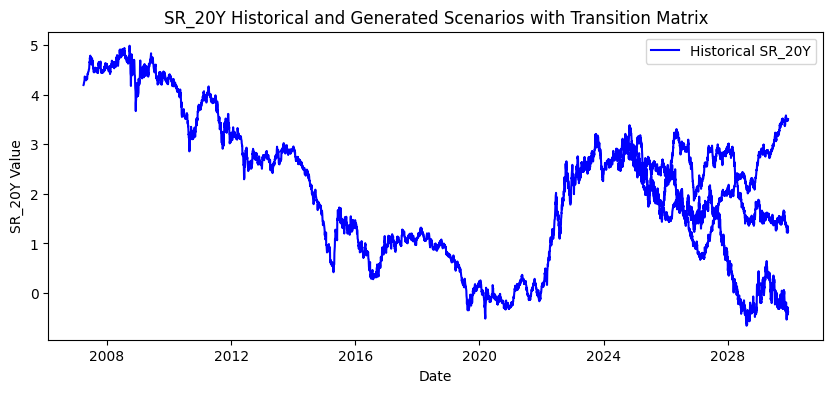

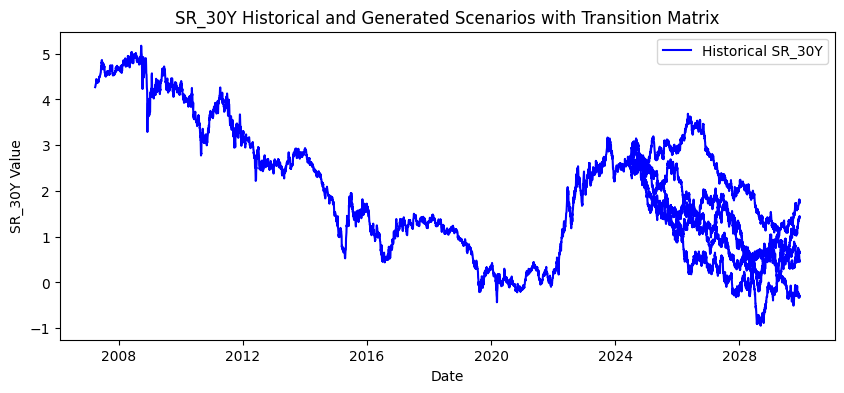

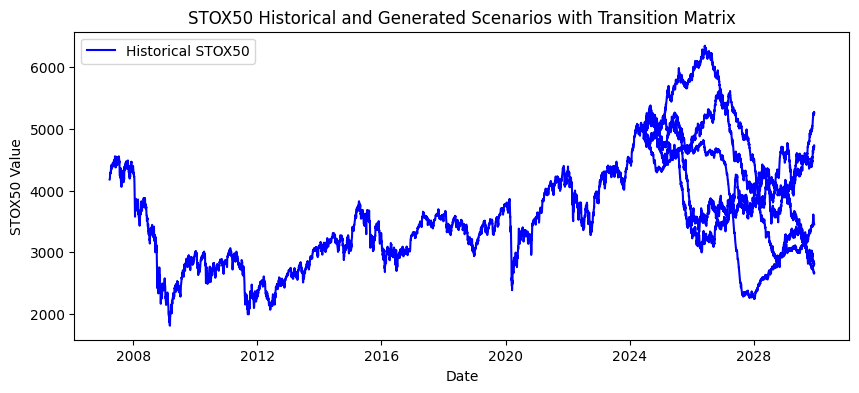

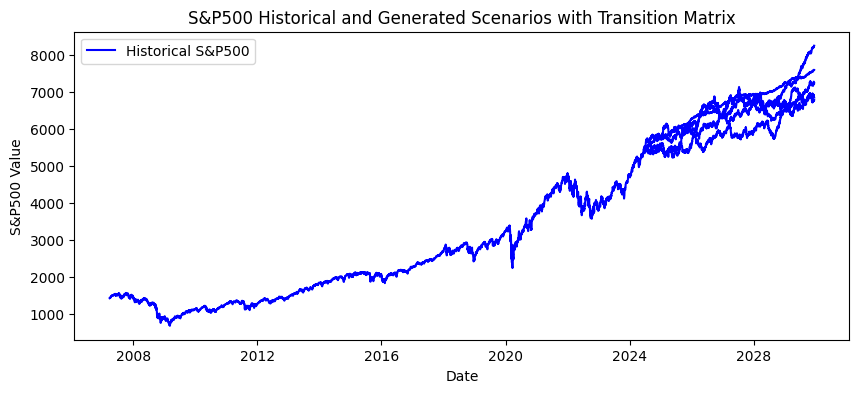

In [130]:


num_scenarios_per_sample = z.shape[0]
# Normalisation des probabilités
for key in dico_proba.keys():
    dico_proba[key] = normaliser_probabilites(dico_proba[key])

# Calcul des matrices de transition
matrices_transition = calculer_matrice_transition(dico_proba)




# Génération de scénarios pour chaque colonne de la base de données historique


num_points_to_generate = 2000  # Nombre de points à générer
segment_length = 50  # Longueur de chaque segment

for column in bdd.columns:
    historical_data = bdd[column]
    plt.figure(figsize=(10, 4))
    plt.plot(bdd.index, historical_data, label=f'Historical {column}', color='blue')


    for i in range(5):
      last_historical_value = bdd[column].values[-1]
      last_historical_date = bdd.index[-1]
      # Dictionnaire des pentes
      slopes = dico_slope[column]

              # Génération des valeurs

      generated_values = []
      current_slope_idx = np.random.choice(len(slopes), p=dico_proba[column])
      current_slope = slopes[current_slope_idx]
      start_idx = i * num_scenarios_per_sample
      end_idx = (i + 1) * num_scenarios_per_sample
      generated_data = generated_df[column].iloc[start_idx:end_idx].values
      generated_data =np.cumsum(generated_data)
      x = np.arange(len(generated_data))
      y = generated_data
      A = np.vstack([x, np.ones(len(x))]).T
      m, c = np.linalg.lstsq(A, y, rcond=None)[0]
      #generated_data= normalize_variance(generated_data, historical_data, window_size=200,threshold=1)
      generated_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=num_scenarios_per_sample, freq='D')
      generated_scenarios = generated_data
      if column in ["S&P500","STOX50"]:

        generated_scenarios = generated_data-m*x
        generated_scenarios= normalize_variance(generated_scenarios, bdd_clean[column], 600,5)
      else:

        generated_scenarios = generated_data-m*x
        generated_scenarios= normalize_variance(generated_scenarios, bdd_clean[column], 600,5)
        generated_scenarios=generated_scenarios

        # Génération des segments et ajustement de la pente
      for _ in range(num_points_to_generate // segment_length):
          x = np.arange(segment_length)
          segment = current_slope * x + last_historical_value
          generated_values.extend(segment)
          last_historical_value = segment[-1]

          # Choisir la prochaine pente en utilisant la matrice de transition
          current_slope_idx = np.random.choice(len(slopes), p=matrices_transition[column][current_slope_idx])
          current_slope = slopes[current_slope_idx]
      generated_values_array = np.array(generated_values)+generated_scenarios

      generated_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=num_points_to_generate, freq='D')
      #Filtrage Simple des scenarios
      if np.all(generated_values_array>-1):
       plt.plot(generated_dates, generated_values_array, color='blue', alpha=1)
      # Tracer les scénarios générés
    plt.title(f'{column} Historical and Generated Scenarios with Transition Matrix')
    plt.xlabel('Date')
    plt.ylabel(f'{column} Value')
    plt.legend()
    #plt.gca().axes.get_xaxis().set_visible(False)
    plt.show()
